In [161]:
import pandas as pd
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import argparse

import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### EDA

In [25]:
# Load data, either .csv or .feather
data_df = pd.read_csv("../data/banknote_net.csv", index_col=0)
data_df_feather = pd.read_feather("../data/banknote_net.feather") # feather is faster and more robust that csv.

data_df['currency_denom'] = data_df['Currency'] + '_' + data_df['Denomination']

# Total numbe of images
print(f"Total number of images is {len(data_df)}")

# Unique number of currencies
print(f"Total number of currencies is {len(data_df.Currency.unique())}")

# Unique number of denominations (including back and front of each banknote)
combined_series = data_df.Currency + data_df.Denomination # combination of currency and denomination
print(f"Total number of denominations is {int(len(combined_series.unique()) / 2)}")

# Inspect data structure
data_df.head(15)

Total number of images is 24826
Total number of currencies is 17
Total number of denominations is 112


,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,...,v_249,v_250,v_251,v_252,v_253,v_254,v_255,Currency,Denomination,currency_denom
0,0.000000,0.802783,4.799193,3.520272,3.906448,2.964886,2.276473,0.472117,0.000000,0.351116,...,5.005167,5.144637,0.000000,0.717125,0.0,4.724614,0.000000,AUD,100_1,AUD_100_1
1,1.282011,0.169436,4.367540,4.476254,5.645983,2.173897,0.638572,0.000000,0.149849,0.516939,...,4.548221,2.671707,0.000000,0.317925,0.0,2.648906,0.656381,AUD,100_1,AUD_100_1
2,1.956406,0.000000,5.244660,3.611655,5.085964,3.766434,0.000000,1.865016,2.853455,1.840774,...,6.429610,2.465012,0.000000,0.197883,0.0,0.823947,1.539916,AUD,100_1,AUD_100_1
3,0.382722,3.727718,4.409414,3.093557,6.277169,0.000000,1.368437,0.000000,1.095514,0.958835,...,4.439319,0.273129,0.438889,2.423372,0.0,1.724243,0.000000,AUD,100_1,AUD_100_1
4,0.619588,0.071276,3.780865,3.637381,4.144943,3.829269,0.811821,0.387360,1.005720,1.084254,...,6.559031,4.807416,0.017139,0.000000,0.0,2.969594,0.000000,AUD,100_1,AUD_100_1
5,0.078776,0.644733,2.710341,2.106869,3.037229,4.366678,0.802116,1.219890,1.602621,0.842361,...,5.737626,3.718403,0.000000,0.351575,0.0,3.243896,0.000000,AUD,100_1,AUD_100_1
6,1.471466,0.000000,2.497013,2.721815,3.963496,4.339762,0.898919,1.321742,0.673099,0.845716,...,4.615301,3.797620,0.044359,0.000000,0.0,3.043229,0.000000,AUD,100_1,AUD_100_1
7,1.040910,0.000000,4.119106,4.077905,3.483957,2.926373,0.000000,0.000000,1.758486,1.922651,...,7.756765,2.139086,0.000000,1.238276,0.0,3.162983,0.043580,AUD,100_1,AUD_100_1
8,0.000000,0.408692,3.717778,3.311307,2.718847,2.629820,0.877763,0.296808,1.738931,0.335870,...,6.442374,2.173676,0.000000,1.171402,0.0,3.257974,0.000000,AUD,100_1,AUD_100_1
9,0.225071,0.611859,3.646192,1.171887,2.443441,4.118752,0.973302,0.642363,1.496193,0.830227,...,6.434539,3.712054,0.000000,0.540613,0.0,1.862063,0.000000,AUD,100_1,AUD_100_1


In [8]:
data_df.Currency.value_counts()

TRY    2888
BRL    2078
INR    1921
EUR    1905
JPY    1658
AUD    1616
USD    1604
MYR    1202
IDR    1164
PHP    1164
CAD    1162
NZD    1156
PKR    1131
MXN    1122
GBP    1108
SGD    1015
NNR     932
Name: Currency, dtype: int64

In [11]:
# Choose certain currencies for easier visualization
embedding = data_df.copy(deep=True)
embedding = embedding[
    (embedding["Currency"] == "MXN")
    | (embedding["Currency"] == "USD")
    | (embedding["Currency"] == "EUR")
    | (embedding["Currency"] == "BRL")
    | (embedding["Currency"] == "TRY")
]

# Save currency labels and separate labels from embeddings
labels = embedding["Currency"]
embedding = embedding.drop(["Currency", "Denomination", 'currency_denom'], axis=1)

# Train t-SNE embedding
X = TSNE(n_components=2, perplexity=20.0, n_iter=1000).fit_transform(embedding) # compute t-SNE representation


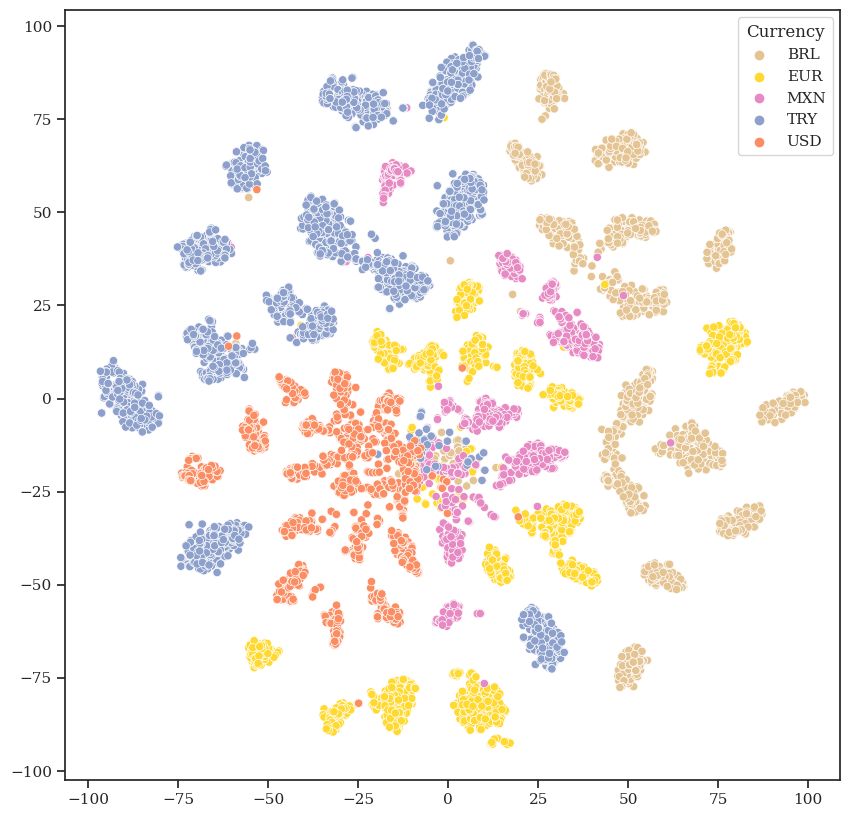

In [12]:
# Make plots
sns.set(font="serif", style="ticks", rc={"figure.figsize": (10, 10)}, context="notebook")
sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=labels,
    palette="Set2_r",
)
# Save figure
plt.savefig('embedding_vis.png', dpi=300)

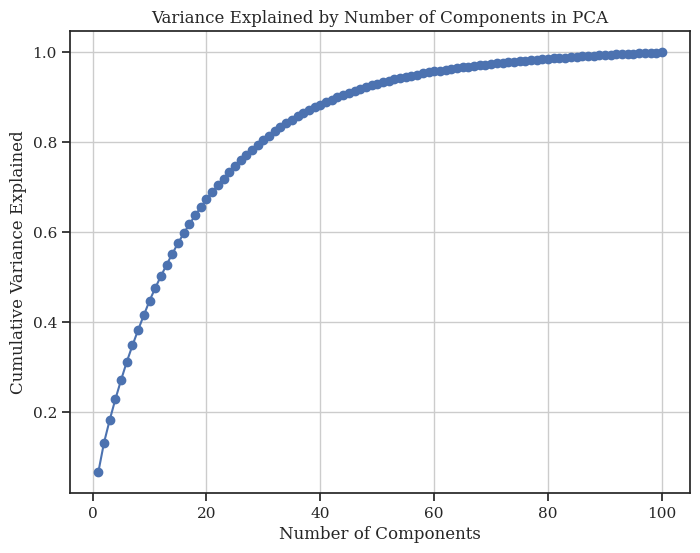

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Assuming 'embedding' and 'labels' are already defined from your code snippet

# Perform PCA
pca = PCA(n_components=100)
X_pca = pca.fit_transform(embedding)

# Function to calculate explained variance
def calculate_variance_explained(X):
    total_variance = np.sum(np.var(X, axis=0))
    explained_variance = np.cumsum(np.var(X, axis=0)) / total_variance
    return explained_variance

# Calculate explained variance for PCA components
explained_variance_pca = calculate_variance_explained(X_pca)

# Plot the explained variance for PCA components
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(explained_variance_pca) + 1), explained_variance_pca, marker='o')
plt.title('Variance Explained by Number of Components in PCA')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()


### Model

In [163]:
currency = "USD"

In [164]:
# load data from embeddings
data = data_df.copy()
data = data[data.Currency == currency]  # Filter currency 
data = data.sample(frac=1)  # Reorder randomly the DF

# Create a variable for both denomination and currencies
labels = data.pop("currency_denom")  # Pop denomination as labels
labels = labels.astype("category")
labels_encoded = pd.get_dummies(labels)
data = data.iloc[:, :-2]  # Keep only embedding

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data, labels_encoded, test_size=0.1, random_state=42
)

# X_train and y_train now contain 90% of the data for training
# X_test and y_test now contain 10% of the data for testing

In [165]:
#def train_model():
"""Trains shallow classifier using embeddings."""

#args = parse_arguments()
#CURRENCY = args.currency
BATCH_SIZE = 128
NB_EPOCH = 25
#PATH = args.dpath



# Define dataset and shallow model
NUM_CLASSES = len(labels.unique())
NB_TRAINING_SAMPLES = len(data)

input = Input(shape=(256,))
x = Dense(128, activation="relu")(input)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES, activation="softmax")(x)
model = Model(inputs=input, outputs=x)
model.summary()

checkpoint = ModelCheckpoint(
    filepath="./src/trained_models/shallow_classifier.h5",
    monitor="val_acc",
    save_best_only=True,
)

# Compile and fit
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(lr=1e-3),
    metrics=[
        "acc",
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

model.fit(
    x=X_train.values,
    y=y_train.values,
    steps_per_epoch=NB_TRAINING_SAMPLES // BATCH_SIZE,
    epochs=NB_EPOCH,
    validation_split=0.2,
    callbacks=[checkpoint],
)



Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 256)]             0         
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 14)                1806      
                                                                 
Total params: 34,702
Trainable params: 34,702
Non-trainable params: 0
_________________________________________________________________


Epoch 1/25
12/12 [==============================] - 0s 13ms/step - loss: 3.1007 - acc: 0.2348 - precision_8: 0.3044 - recall_8: 0.1308 - val_loss: 1.1024 - val_acc: 0.7612 - val_precision_8: 0.9826 - val_recall_8: 0.3910
Epoch 2/25
12/12 [==============================] - 0s 4ms/step - loss: 1.1944 - acc: 0.6352 - precision_8: 0.8852 - recall_8: 0.4610 - val_loss: 0.6550 - val_acc: 0.8443 - val_precision_8: 0.9803 - val_recall_8: 0.6886
Epoch 3/25
12/12 [==============================] - 0s 4ms/step - loss: 0.8205 - acc: 0.7756 - precision_8: 0.9310 - recall_8: 0.6317 - val_loss: 0.5203 - val_acc: 0.8581 - val_precision_8: 0.9729 - val_recall_8: 0.7439
Epoch 4/25
12/12 [==============================] - 0s 4ms/step - loss: 0.6255 - acc: 0.8206 - precision_8: 0.9569 - recall_8: 0.7305 - val_loss: 0.4266 - val_acc: 0.8927 - val_precision_8: 0.9784 - val_recall_8: 0.7855
Epoch 5/25
12/12 [==============================] - 0s 4ms/step - loss: 0.5369 - acc: 0.8388 - precision_8: 0.9578 - re

In [166]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predictions
predictions = model.predict(X_test, batch_size=1)
predictions = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test.values, axis=1)


# Evaluate
accuracy = accuracy_score(true_labels, predictions)
classification_report_str = classification_report(true_labels, predictions)
confusion_mat = confusion_matrix(true_labels, predictions)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report_str)
print("Confusion Matrix:\n", confusion_mat)


161/161 [==============================] - 0s 380us/step
Accuracy: 0.8881987577639752
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       1.00      1.00      1.00        11
           2       0.75      0.67      0.71         9
           3       0.88      0.88      0.88         8
           4       0.85      0.92      0.88        12
           5       1.00      0.82      0.90        11
           6       0.82      0.82      0.82        11
           7       1.00      0.88      0.93         8
           8       0.79      0.83      0.81        18
           9       0.86      0.86      0.86         7
          10       1.00      0.92      0.96        13
          11       0.93      1.00      0.97        14
          12       0.82      0.90      0.86        10
          13       0.88      0.78      0.82         9

    accuracy                           0.89       161
   macro avg       0.89 

In [167]:
unique_classes_true = np.unique(true_labels)
unique_classes_pred = np.unique(predictions)
print("Unique Classes in True Labels:", unique_classes_true)
print("Unique Classes in Predicted Labels:", unique_classes_pred)

Unique Classes in True Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Unique Classes in Predicted Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [168]:


usd_indices = [index for index, value in enumerate(list(y_test.columns)) if currency in value]
usd_values = [value for value in list(y_test.columns) if currency in value]

print(f"{currency} Indices:", usd_indices)
print(f"{currency} Values:", usd_values)

USD Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
USD Values: ['USD_100_1', 'USD_100_2', 'USD_10_1', 'USD_10_2', 'USD_1_1', 'USD_1_2', 'USD_20_1', 'USD_20_2', 'USD_2_1', 'USD_2_2', 'USD_50_1', 'USD_50_2', 'USD_5_1', 'USD_5_2']


In [177]:
true_labels

array([13,  8,  1,  2,  6,  5,  2,  5,  8,  0,  0,  8, 10,  5,  3, 12,  1,
        9, 11, 12,  5,  4,  8,  7,  6,  1, 11, 11,  5,  4,  9,  0, 12,  8,
        4, 12, 13,  1,  3,  7,  3,  0,  0,  5,  6,  6,  5,  6, 12,  2,  3,
       11,  0, 10,  9, 11,  4,  7,  9,  7,  9, 10,  8,  1,  0,  2, 11, 10,
       12,  4,  3, 11,  0,  0,  4, 10, 10,  8,  6,  9,  0, 12,  4,  8, 11,
       11, 11,  0,  6, 12,  0,  6,  2,  4,  1,  8, 13, 11,  7,  0, 10,  6,
        0, 10, 13,  0, 11,  7,  8,  0,  8,  3,  8,  3,  7, 13,  2,  0,  1,
       12,  3,  1,  9,  4, 13, 13,  0,  5,  1, 11,  2, 10,  1,  8,  4,  8,
       13, 10,  4,  0,  5, 12,  0,  7,  6,  2, 13, 10,  8,  1, 11, 10,  5,
        6,  4, 10,  2,  8,  8,  5,  8])

In [178]:
predictions

array([13,  8,  1,  2,  2,  5,  4,  5,  8,  0,  0,  8,  6,  0,  3, 12,  1,
        3, 11,  6,  5,  4,  8,  7,  6,  1, 11, 11,  5,  4,  9,  0, 12,  9,
        8, 12, 13,  1,  3,  7,  3,  0,  0,  2,  8,  6,  5,  6, 12,  2, 13,
       11,  0, 10,  9, 11,  4,  7,  9,  7,  9, 10,  8,  1,  0, 12, 11, 10,
       12,  4,  3, 11,  0,  0,  4, 10, 10,  4,  6,  9,  0, 12,  4,  8, 11,
       11, 11,  0,  6, 12,  0,  6,  2,  4,  1,  8, 13, 11,  7,  0, 10,  6,
        0, 10, 13,  0, 11,  8,  8,  0,  8,  3,  8,  3,  7, 11, 12,  0,  1,
       12,  3,  1,  9,  4, 13,  8,  0,  5,  1, 11,  2, 10,  1,  8,  4,  8,
       13, 10,  4,  0,  5, 12,  0,  7,  6,  2, 13, 10,  8,  1, 11, 10,  5,
        6,  4, 10,  2,  0,  8,  5,  8])

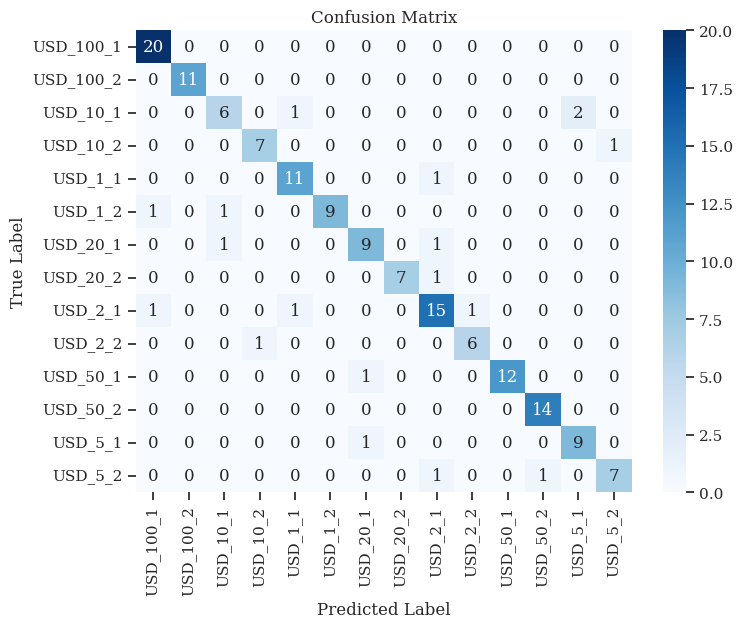

In [169]:
confusion_mat = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=list(y_train.columns), yticklabels=list(y_train.columns))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Predict custom

In [157]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input

# Assuming IMG_SIZE is defined elsewhere in your code
IMG_SIZE = (224, 224)

# Load the pre-trained encoder model
encoder_model = load_model("../models/banknote_net_encoder.h5")

# Input tensor with shape (IMG_SIZE[0], IMG_SIZE[1], 3)
input1 = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Apply the encoder model to transform input1 to the desired shape (256,)
output_of_encoder = encoder_model(input1)

# Create a new model with the transformed input
model_with_transformed_input = Model(inputs=input1, outputs=output_of_encoder)


# Use the model to predict the class of the input
input_image = tf.keras.preprocessing.image.load_img("/Users/nicolasrey/Documents/MSBA/Fall/ML/Project/custom_train/5_1/2_12.jpeg", target_size=IMG_SIZE)
input_image_array = tf.keras.preprocessing.image.img_to_array(input_image)
input_image_array = tf.expand_dims(input_image_array, axis=0)

# Transform the input using the model_with_transformed_input
transformed_input = model_with_transformed_input.predict(input_image_array)

# Use the pre-trained "model" to predict the class
predictions = model.predict(transformed_input)
predictions = np.argmax(predictions, axis=1)
print("Predictions:")
print(predictions)


1/1 [==============================] - 0s 15ms/step
Predictions:
[0]


In [159]:
list(y_train.columns)[0]

'USD_100_1'

In [160]:
list(y_train.columns)

['USD_100_1',
 'USD_100_2',
 'USD_10_1',
 'USD_10_2',
 'USD_1_1',
 'USD_1_2',
 'USD_20_1',
 'USD_20_2',
 'USD_2_1',
 'USD_2_2',
 'USD_50_1',
 'USD_50_2',
 'USD_5_1',
 'USD_5_2']

In [156]:
model.predict(transformed_input)

1/1 [==============================] - 0s 15ms/step


array([[0.36753047, 0.02710198, 0.00680986, 0.13015577, 0.0147844 ,
        0.00347947, 0.00895698, 0.00062209, 0.42459935, 0.00861615,
        0.00217029, 0.00090689, 0.0012865 , 0.00297988]], dtype=float32)